# Problem Background: The Great Migration

In our ongoing efforts to ensure the safety of the migration to Earth Junior, we have developed a linear regression model that produces a human-zombie score ranging from 0 to 100. This score is designed to assess the likelihood of individuals being human or zombie based on various features collected during screening.

To enhance our security measures, the spaceship station has deployed a specialized automated barrier system that utilizes the human-zombie scores to classify individuals into three distinct categories:

- **Class 0: Score Range 0-33**: **Most Likely Human**  
  Individuals in this range will be directed straight to the spaceship for immediate boarding.

- **Class 1: Score Range 33-66**: **Need Further Tests**  
  Those with scores in this range will be redirected to a testing facility for additional examinations to confirm their identity. They will be quarantined for a two-week observational period to ensure they do not pose a risk.

- **Class 3: Score Range 66-100**: **Most Likely Zombies**  
  Those scoring in this highest range will be denied entry to the spaceship, as they are deemed a significant threat to the safety of the remaining human population.

This classification system aims to maximize the chances of a successful migration while ensuring that the risk of zombie infiltration is minimized.


# Logistic Regression  


<center>
  <img src = "https://miro.medium.com/v2/resize:fit:1100/format:webp/1*RElrybCZ4WPsUfRwDl7fqA.png">
</center>



## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
dataset = pd.read_csv('data/human_zombie_dataset_v5.csv')


# Preprocessing  
   

In [3]:
# Transform Labels
def transform_labels(dataset):
    conditions = [
        (dataset['Human-Zombie Score'] <= 33),  
        (dataset['Human-Zombie Score'] > 33) & (dataset['Human-Zombie Score'] <= 66),  
        (dataset['Human-Zombie Score'] > 66)  
    ]
    codes = [0, 1, 2]  
    dataset['Category'] = np.select(conditions, codes, default=0)
    return dataset

In [4]:
# Train Test Split
def perform_train_test_split(dataset):
    X = dataset.drop(columns=['Human-Zombie Score', 'Category'])  
    y = dataset['Category'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [5]:
class StandardScaler:
    def __init__(self):
        self.means = None
        self.stds = None
    
    def fit(self, X):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
    
    def transform(self, X):
        if self.means is None or self.stds is None:
            raise ValueError("The scaler has not been fitted yet")
        return (X - self.means) / self.stds

def normalize_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)  
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled



In [6]:
dataset = transform_labels(dataset)

X_train, X_test, y_train, y_test = perform_train_test_split(dataset)

X_train_scaled, X_test_scaled = normalize_data(X_train, X_test)

# print(f"Training set shape: {X_train_scaled.shape}")
# print(f"Test set shape: {X_test_scaled.shape}")

## Part A: Implementation from Scratch  

In [7]:

class RegularizedLogisticRegression:
    def __init__(self, learning_rate=0.001, num_iterations=1000, lambda_reg=1):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None

    def sigmoid(self, x):
        x = np.clip(x, -709, 709)  
        return 1 / (1 + np.exp(-x))

    def cross_entropy_loss(self, y_true, y_pred):
        m = len(y_true)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -(1/m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        reg_loss = (self.lambda_reg / (2 * m)) * np.sum(np.square(self.weights))
        return loss + reg_loss


    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self.weights = np.zeros(n)
        self.bias = 0
        loss_history = [] 

        for i in range(self.num_iterations):
            linear_output = np.dot(X_train, self.weights) + self.bias
            y_pred = self.sigmoid(linear_output)
            dw = (1/m) * np.dot(X_train.T, (y_pred - y_train)) + (self.lambda_reg / m) * self.weights
            db = (1/m) * np.sum(y_pred - y_train)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = self.cross_entropy_loss(y_train, y_pred)
            loss_history.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i} | Loss: {loss}")

        return loss_history

    def predict(self, X_test):
        linear_output = np.dot(X_test, self.weights) + self.bias
        y_pred_prob = self.sigmoid(linear_output)
        y_pred_label = (y_pred_prob >= 0.5).astype(int)
        return y_pred_prob, y_pred_label

    def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        return accuracy, f1, np.array([[TN, FP], [FN, TP]])


# Implement One vs All Classification 

Iteration 0 | Loss: 0.693147184288491
Iteration 100 | Loss: 0.21288264046484381
Iteration 200 | Loss: 0.17690888085012033
Iteration 300 | Loss: 0.15960820484111538
Iteration 400 | Loss: 0.1489923848770848
Iteration 500 | Loss: 0.1416732401403205
Iteration 600 | Loss: 0.13626857274782378
Iteration 700 | Loss: 0.1320916099797103
Iteration 800 | Loss: 0.12875637104834733
Iteration 900 | Loss: 0.12602680035661865
Iteration 1000 | Loss: 0.12374933268388698
Iteration 1100 | Loss: 0.12181923014129124
Iteration 1200 | Loss: 0.12016233270201174
Iteration 1300 | Loss: 0.11872450932531542
Iteration 1400 | Loss: 0.11746523852198154
Iteration 1500 | Loss: 0.11635353339669992
Iteration 1600 | Loss: 0.11536526192407165
Iteration 1700 | Loss: 0.11448133104764924
Iteration 1800 | Loss: 0.11368642393851874
Iteration 1900 | Loss: 0.11296810194372825
Iteration 0 | Loss: 0.6931471805724857
Iteration 100 | Loss: 0.617572408959669
Iteration 200 | Loss: 0.6159605848586805
Iteration 300 | Loss: 0.6157405638326

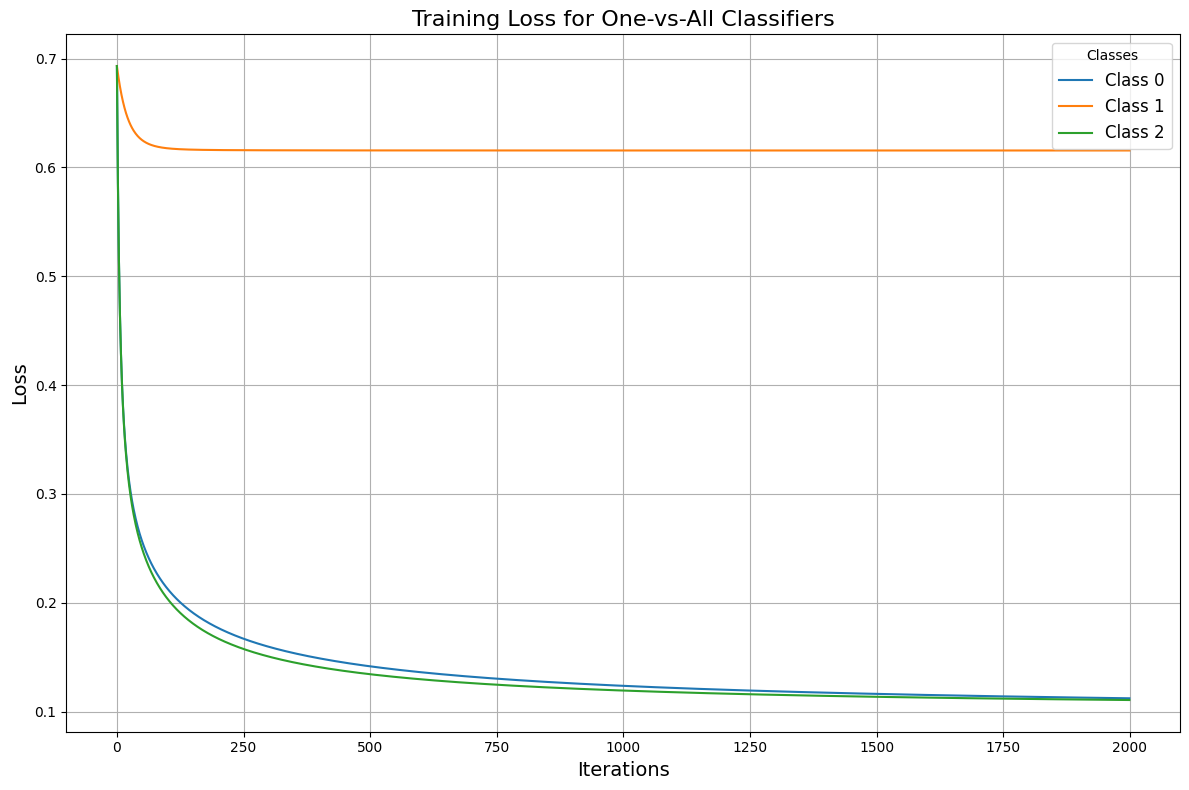

Final loss for Class 0: 0.1123
Final loss for Class 1: 0.6156
Final loss for Class 2: 0.1107


In [8]:

import matplotlib.pyplot as plt

classifiers = {}
losses = {}  

for i in range(3):
    y_binary = (y_train == i).astype(int)  
    
    classifier = RegularizedLogisticRegression(learning_rate=0.1, num_iterations=2000, lambda_reg=0.001)
    loss_history = classifier.fit(X_train_scaled, y_binary) 
    
    classifiers[i] = classifier  
    losses[i] = loss_history  

plt.figure(figsize=(12, 8))  
for i in range(3):
    plt.plot(losses[i], label=f'Class {i}')  
plt.title('Training Loss for One-vs-All Classifiers', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(title="Classes", loc="upper right", fontsize=12)
plt.grid(True)
plt.tight_layout() 
plt.show()
for i in range(3):
    print(f'Final loss for Class {i}: {losses[i][-1]:.4f}')


# Evaluate  

In [9]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

results = {
    'Class': [],
    'Probs': [],
    'Accuracy': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

overall_probs = []

for i in range(3):  
    probability, predicted_class = classifiers[i].predict(X_test_scaled)
    overall_probs.append(probability)
    
    y_binary_test = (y_test == i).astype(int)
    
    accuracy = accuracy_score(y_binary_test, predicted_class)
    f1 = f1_score(y_binary_test, predicted_class)
    cm = confusion_matrix(y_binary_test, predicted_class)
    
    results['Class'].append(i)
    results['Probs'].append(probability)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)

results_df = pd.DataFrame(results)



In [10]:
results_df.drop('Probs',axis=1)

,Class,Accuracy,F1 Score,Confusion Matrix
0,0,0.965,0.944000,"[[134, 5], [2, 59]]"
1,1,0.620,0.000000,"[[124, 0], [76, 0]]"
2,2,0.950,0.921875,"[[131, 6], [4, 59]]"


In [11]:
# # Multi class evaluations.
class_labels = ['Class 0: Most Likely Human', 
                'Class 1: Further Testing', 
                'Class 2: Most Likely Zombie']

combined_probs = np.array(overall_probs)  
final_preds = np.argmax(combined_probs, axis=0)

In [12]:
# Calculate the macro f1, accuracy and confusion matrix for multiclass classification

macro_f1 = f1_score(y_test, final_preds, average='macro')
multiclass_accuracy = accuracy_score(y_test, final_preds)
multiclass_cm = confusion_matrix(y_test, final_preds)

print("\nMulticlass Evaluation:")
print(f"  Macro F1 Score: {macro_f1:.4f}")
print(f"  Accuracy: {multiclass_accuracy:.4f}")
print(f"  Confusion Matrix:\n{multiclass_cm}")


Multiclass Evaluation:
  Macro F1 Score: 0.8853
  Accuracy: 0.8850
  Confusion Matrix:
[[61  0  0]
 [11 56  9]
 [ 0  3 60]]


# Part B: Use Scikit-learn  

Scikit-learn Logistic Regression Evaluation:
  Accuracy: 0.9100
  Macro F1 Score: 0.9092
  Confusion Matrix:
[[59  2  0]
 [ 6 64  6]
 [ 0  4 59]]


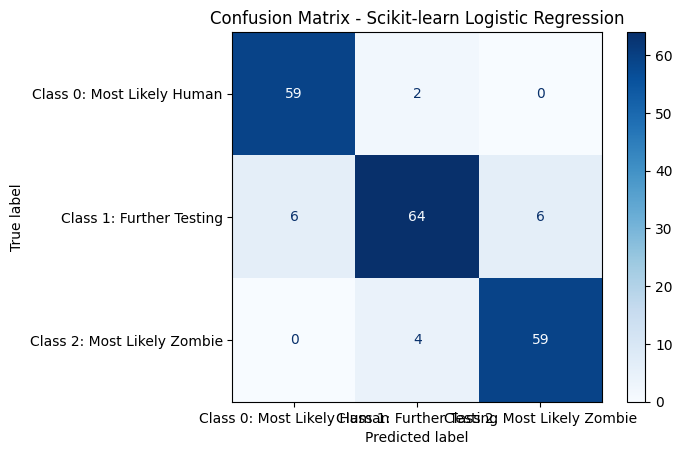

In [13]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

clf = LogisticRegression()  

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  
cm = confusion_matrix(y_test, y_pred)

print("Scikit-learn Logistic Regression Evaluation:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Macro F1 Score: {f1:.4f}")
print("  Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Scikit-learn Logistic Regression')
plt.show()
